In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import dask_geopandas
import contextily as ctx

In [2]:
panel = gpd.read_feather('../data/panel_data_estimated_costs.geofeather')

In [3]:
panel.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

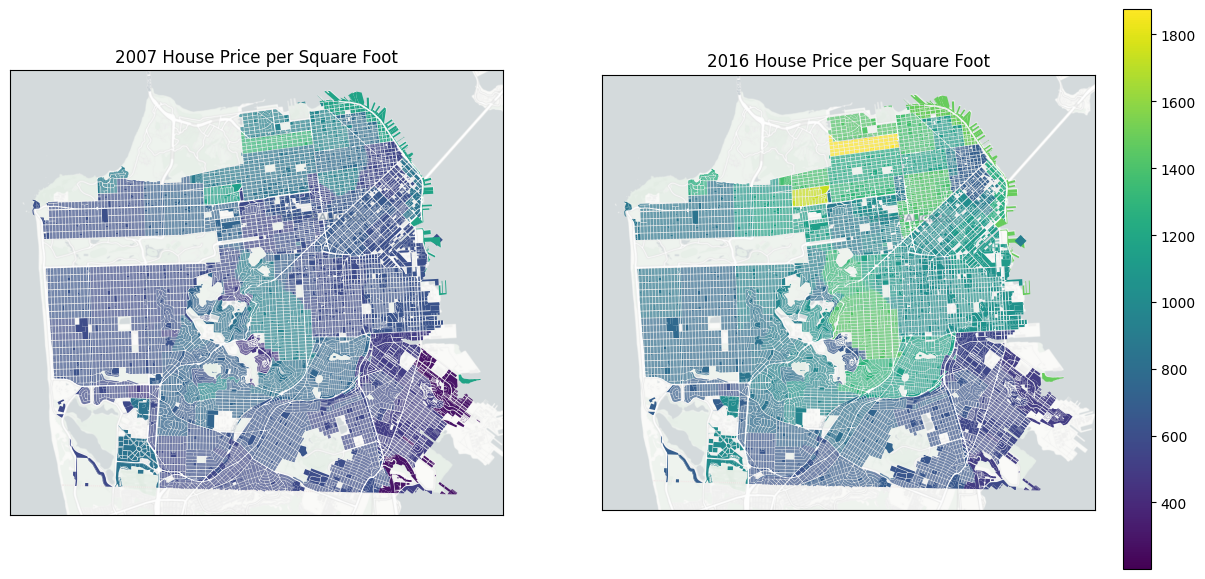

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
vmin, vmax = panel['sqft_price'].min(), panel['sqft_price'].max()

ax1 = panel.query('closed_roll_year == 2016').plot(column='sqft_price', legend=False, ax=axes[1], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[1])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("2016 House Price per Square Foot")

ax2 = panel.query('closed_roll_year == 2007').plot(column='sqft_price', legend=False, ax=axes[0], vmin=vmin, vmax=vmax)
ctx.add_basemap(crs=3310, attribution=False, source=ctx.providers.CartoDB.Positron, ax=axes[0])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("2007 House Price per Square Foot")

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []  # Fake up the array of the scalar mappable
fig.colorbar(sm, cax=cax)

plt.savefig('combined_sqft_price.png')

In [5]:
# Update x, y to be based on parcel shapefile geometry and not tax shapefile geometry
panel['x'] = panel.geometry.centroid.x
panel['y'] = panel.geometry.centroid.y

In [6]:
panel = panel[panel['geometry'].notna()]

### Unit count data

In [7]:
homes = pd.read_excel('../data/Housing Production 2005-2022.xlsx')

In [8]:
dbi = gpd.read_feather('../data/dbi_permits.geofeather')

In [9]:
date_cols = [c for c in dbi.columns if 'date' in c]
dbi[date_cols] = dbi[date_cols].apply(lambda x: pd.to_datetime(x, errors='coerce'))
cost_cols = [c for c in dbi.columns if 'cost' in c]
dbi[cost_cols] = dbi[cost_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
unit_cols = [c for c in dbi.columns if 'unit' in c]
dbi[unit_cols] = dbi[unit_cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [10]:
dbi = dbi.sort_values('permit_creation_date', ascending=False)
dbi = dbi.drop_duplicates('permit_number')

# NB: 5 rows in homes don't match-
permits = pd.merge(dbi[['geometry', 'permit_number', 'permit_creation_date']],
                   homes,
                   left_on='permit_number', right_on='BPA', how='inner')
permits = permits[['geometry', 'permit_number', 'Permit Issued Date', 'permit_creation_date',
                   'Net_Units_Completed', 'Date_Completed', 'BlockLot']]


In [11]:
permits = permits[permits['Net_Units_Completed'] > 0]

In [12]:
df_list = []

for year in range(2007, 2017):
    parcels_year = panel[panel.year == year].copy()
    permits_year = permits[permits['permit_creation_date'].dt.year == year].copy()
    df_list.append(gpd.sjoin(parcels_year, permits_year.to_crs(panel.crs), how='left', predicate='contains'))

In [13]:
panel.Developed.sum()

341

In [14]:
result = pd.concat(df_list, axis=0)

In [15]:
nuc_agg = result.groupby(['MapBlkLot_Master', 'year']).agg({'Net_Units_Completed': 'sum'}).reset_index()

In [16]:
result = result.drop_duplicates(['MapBlkLot_Master', 'year'])

In [17]:
result = pd.merge(result.drop(columns='Net_Units_Completed'), nuc_agg, on=['MapBlkLot_Master', 'year'])

In [18]:
result.shape

(1530794, 72)

In [19]:
result = result.drop(columns='index_right')

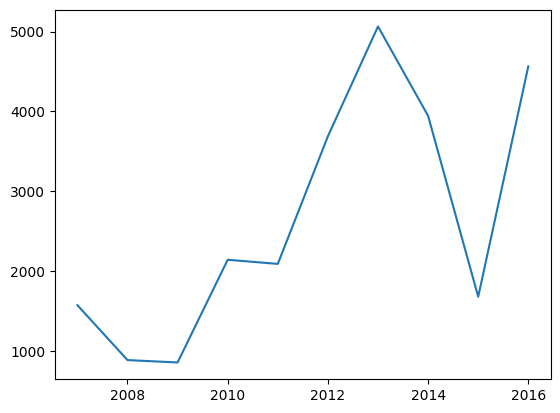

In [20]:
plt.plot(result.groupby('year').agg({'Net_Units_Completed': 'sum'}))

In [21]:
result.Developed = result.permit_number.notna()

In [22]:
result.Developed.sum()

1831

### Fires

In [23]:
fires = gpd.read_feather('../data/clean_accidental_fires.geofeather')

In [24]:
fires.to_crs(result.crs, inplace=True)

In [25]:
panel_fires = gpd.sjoin(result,
                        fires[['geometry',
                               'estimated_property_loss',
                               'incident_date']].rename(columns= 
                                                        {'estimated_property_loss' : 'fire_damage', 
                                                         'incident_date': 'fire_date'}), 
                        how='left',
                        predicate='contains')

In [26]:
panel_fires.index_right.notna().sum()

3479

In [27]:
panel_fires = panel_fires.drop(columns=['index_right'])

In [28]:
panel_fires.fire_damage.fillna(0, inplace=True)

In [29]:
panel_fires['years_since_fire'] = panel_fires.year - panel_fires.fire_date.dt.year

In [30]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()]

278        -4.0
1982       -7.0
5338      -11.0
10078      -6.0
11812     -10.0
           ... 
1526412    -5.0
1526466     9.0
1528836    -1.0
1529871    -6.0
1530706    11.0
Name: years_since_fire, Length: 3479, dtype: float64

In [31]:
panel_fires['years_since_fire'][panel_fires['years_since_fire'].notna()].describe()

count    3479.000000
mean        0.574590
std         6.663876
min       -16.000000
25%        -4.000000
50%         2.000000
75%         6.000000
max        13.000000
Name: years_since_fire, dtype: float64

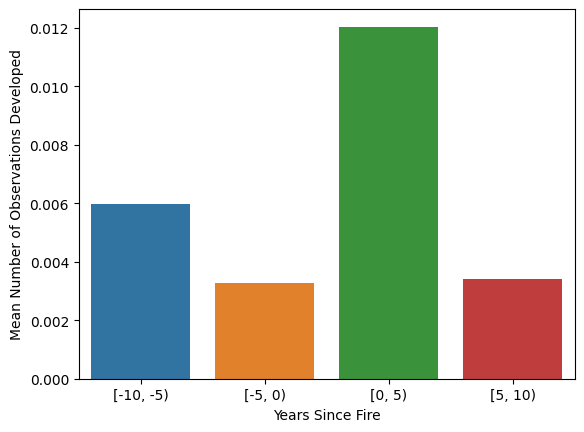

In [32]:
# Compute the mean for each unique value of 'years_since_fire'
to_plot = panel_fires.copy()
to_plot['years_since_fire_bucket'] = pd.cut(to_plot['years_since_fire'], bins=range(-10, 11, 5), right=False)
to_plot = to_plot.groupby('years_since_fire_bucket')['Developed'].mean().reset_index()

# Plot using seaborn
sns.barplot(x='years_since_fire_bucket', y='Developed', data=to_plot)
plt.ylabel('Mean Number of Observations Developed')
plt.xlabel('Years Since Fire')
plt.show()

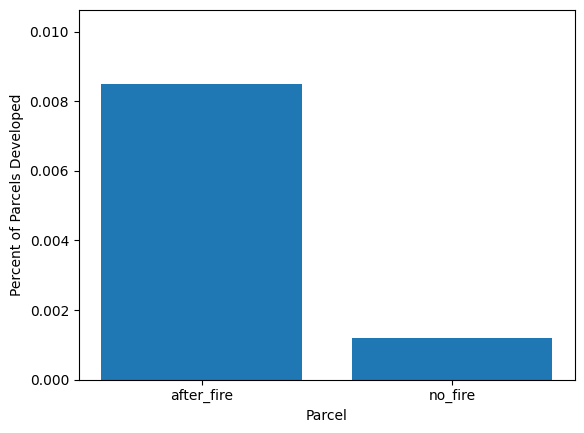

In [33]:
panel_fires['fire_category'] = np.where(panel_fires['years_since_fire'].fillna(-1) < 0, 'no_fire', 'after_fire')

# Compute the mean for each category
plot_data = panel_fires.groupby('fire_category')['Developed'].mean().reset_index()

# Plot using matplotlib
plt.bar(plot_data['fire_category'], plot_data['Developed'])

# Set y-axis limit to 110% of the maximum value
plt.ylim(0, plot_data['Developed'].max() * 1.25)

plt.ylabel('Percent of Parcels Developed')
plt.xlabel('Parcel')
plt.show()

### Revenue & Cost

In [64]:
panel_fires['revenue'] = panel_fires['sqft_price'] * panel_fires['Envelope_1000'] * 1000 / 30

In [65]:
panel_fires.columns

Index(['MapBlkLot_Master', 'year', 'Developed', 'Historic',
       'Residential_Dummy', 'Zillow_Price_Real', 'Const_FedReserve_Real',
       'Envelope_1000', 'Upzone_Ratio', 'zp_OfficeComm', 'zp_DensRestMulti',
       'zp_FormBasedMulti', 'zp_PDRInd', 'zp_Public', 'zp_Redev', 'zp_RH2',
       'zp_RH3_RM1', 'geometry', 'mapblklot', 'property_class_code_definition',
       'lot_code', 'property_area', 'volume_number', 'percent_of_ownership',
       'misc_exemption_value', 'zoning_code', 'year_property_built',
       'analysis_neighborhood', 'number_of_units', 'use_definition',
       'closed_roll_year', 'status_code', 'number_of_bedrooms',
       'assessor_neighborhood', 'number_of_stories',
       'assessor_neighborhood_district', 'exemption_code_definition', 'block',
       'current_sales_date', 'lot_area', 'number_of_rooms', 'lot_depth',
       'assessed_personal_property_value', 'supervisor_district_2012',
       'number_of_bathrooms', 'construction_type', 'lot_frontage',
       'hom

In [66]:
panel_fires['costs'] = (panel_fires['construction_cost_est'] 
                        + np.maximum(panel_fires['imputed_fair_market_acquisition'] - panel_fires['fire_damage'], 0))

In [67]:
panel_fires['costs']

0          2.495993e+07
1          5.287091e+07
2          3.151963e+05
3          1.025149e+06
4          7.382555e+05
               ...     
1530789    6.903314e+05
1530790    2.785223e+06
1530791    1.040481e+06
1530792    1.891363e+06
1530793             NaN
Name: costs, Length: 1531273, dtype: float64

In [68]:
panel_fires['revenue'] 

0          3.372075e+06
1          2.744964e+06
2          3.782784e+04
3          3.927322e+04
4          5.971198e+04
               ...     
1530789    1.250667e+05
1530790    1.293656e+05
1530791    1.421000e+05
1530792    4.898656e+05
1530793             NaN
Name: revenue, Length: 1531273, dtype: float64

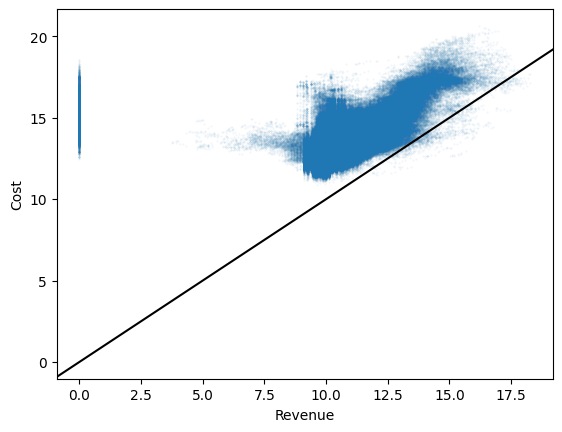

In [69]:
f, ax = plt.subplots()
plt.scatter(np.log1p(panel_fires['revenue']), np.log1p(panel_fires['costs']), alpha=.1, s=.1)
plt.xlabel('Revenue')
plt.ylabel('Cost')
ax.axline((0, 0), slope=1, color='black')
plt.show()

In [55]:
panel_fires['fire_damage'].max()

13200000.0

In [39]:
panel_fires['revenue'].max()

2600526059.778

KeyboardInterrupt: 

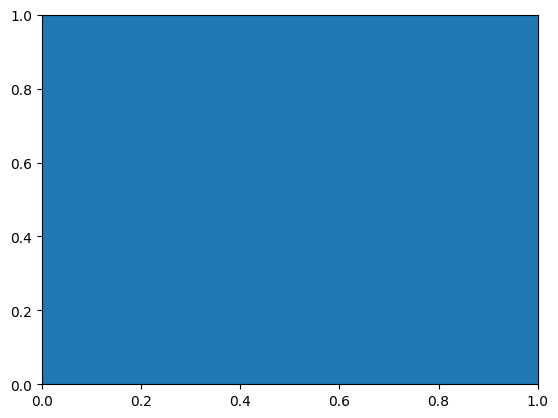

In [40]:
plt.hist(np.log1p(panel_fires['revenue'] / panel_fires['costs']), bins=40)
plt.xlim(0, 100)

In [ ]:
result = panel_fires.groupby('Developed').apply(lambda x: (x['revenue'] / x['costs']).mean())

# Create the bar plot
result.plot(kind='bar', ylabel='Mean Revenue / Costs', title='Mean Revenue Divided by Costs for Developed and Not Developed Groups')
plt.xticks(ticks=[0, 1], labels=['Not Developed', 'Developed'], rotation=0)
plt.show()

In [ ]:
panel_fires.to_csv('./panel_fires.csv', index=False)